In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import helper
from sklearn.model_selection import train_test_split

In [9]:
# Loading and splitting dataset
# Here I have downloaded the data into a folder with labels as its subfolder.
# The train and validation division will be done by train_test split once the dataset is converted into the dictionary by sklearn
# not dividing the data beforehand in training and test set manually will not let you apply separate transfroms to the training and the validation set
# Hence 
# Option 1) if you let sklearn divide the data from a big collection having sub-folders as labels
# then define a single transform for the whole data
# Option 2) Randomly divide the data into train and test directory with labels as their respective sub-folders.
# Define the transforms separately for each of them 

# Defining the transforms: here you can define three separate transforms one for whole dataset and 2 for each of the training and the testing set 

#For Now going with option 1 by defining a single transform

def Splitter(dataset,val_split):
    train_idx,val_idx = train_test_split(list(range(len(dataset))),test_size=val_split) #this function segregates list of indexes in the ratio provided for split randomly and assigns back the 2 segregated parts of the list
    Data = {} #making an empty dictionary for Data
    Data['train'] = torch.utils.data.Subset(dataset,train_idx) #Assign the subset corresponding to the index from dataset to the key train in dictionary Data
    Data['test'] = torch.utils.data.Subset(dataset,val_idx) 
    return Data

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
dataset= torchvision.datasets.ImageFolder('./PetImages',transform)
Data = Splitter(dataset,0.3)
print(len(Data['train']))
print(len(Data['test']))



17500
7500


In [10]:
#Defining dataloader
trainloader = torch.utils.data.DataLoader(Data['train'],batch_size=64,shuffle = True)
testloader = torch.utils.data.DataLoader(Data['test'],batch_size=64,shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

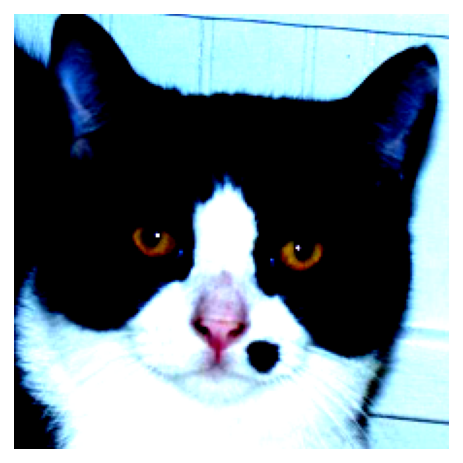

In [11]:
# Run this to test your data loader
images, labels = next(iter(trainloader))
helper.imshow(images[0], normalize=False)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Step 1  Load the pre-trained model
model = models.resnet50(pretrained=True)
model

# Step 2 Turn off Gradients for the parameters of the model
for p in model.parameters():
    p.requires_grad = False   #speeds up and also make sure that they are not updated

# Step 3 Define the new classifier
from collections import OrderedDict

classifier =  nn.Sequential(OrderedDict([('fc1',nn.Linear(2048,512)),
                                        ('relu',nn.ReLU()),
                                        ('fc2',nn.Linear(512,2)),
                                        ('output',nn.LogSoftmax(dim=1))]))
model.fc = classifier

#Step 4 Define Loss and Optimizer and sen model to GPU

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.fc.parameters(), lr =0.002) # passing the parameters which have to be updated,not all.

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# Step  5 Define the training and validation looping over epochs
# Initialize the variables required while training 
# In this setting test runs for one epoch after print_every(5) iterations of training 
Epochs = 2
running_loss = 0
print_every = 5
steps = 0

for e in range(Epochs):
    
    for images, labels in trainloader:
            images, labels = images.to(device) , labels.to(device)
            steps +=1
            optimizer.zero_grad()
            logps = model(images)
            loss = criterion(logps,labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()  # running_lossads till print_every number of iterationx
            #here .item() make sure that variable is back on CPU
            
            if (steps % print_every) ==0:
                model.eval()
                test_loss = 0 # test loss for one epoch
                accuracy = 0  #test accuracy of one epoch
                for images, labels in testloader:
                    images, labels = images.to(device) , labels.to(device)
                    logps = model(images)
                    loss = criterion(logps,labels)
                    test_loss += loss.item()
                    
                    # calculating accuracy
                    probability = torch.exp(logps)
                    top_value, top_class = probability.topk(1,dim=1) #k=1 and search along column
                    equality = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
                
                print(f"Epoch {e+1}/{Epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
                
                running_loss=0
                model.train()

Epoch 1/2.. Train loss: 1.232.. Test loss: 1.191.. Test accuracy: 0.584
Epoch 1/2.. Train loss: 0.437.. Test loss: 0.095.. Test accuracy: 0.965
Epoch 1/2.. Train loss: 0.184.. Test loss: 0.259.. Test accuracy: 0.892
Epoch 1/2.. Train loss: 0.079.. Test loss: 0.075.. Test accuracy: 0.973
Epoch 1/2.. Train loss: 0.088.. Test loss: 0.097.. Test accuracy: 0.959
Epoch 1/2.. Train loss: 0.100.. Test loss: 0.061.. Test accuracy: 0.977
Epoch 1/2.. Train loss: 0.130.. Test loss: 0.118.. Test accuracy: 0.954
Epoch 1/2.. Train loss: 0.109.. Test loss: 0.062.. Test accuracy: 0.977
Epoch 1/2.. Train loss: 0.159.. Test loss: 0.074.. Test accuracy: 0.971
Epoch 1/2.. Train loss: 0.071.. Test loss: 0.144.. Test accuracy: 0.945
Epoch 1/2.. Train loss: 0.120.. Test loss: 0.052.. Test accuracy: 0.980
Epoch 1/2.. Train loss: 0.066.. Test loss: 0.065.. Test accuracy: 0.976
Epoch 1/2.. Train loss: 0.045.. Test loss: 0.074.. Test accuracy: 0.970
Epoch 1/2.. Train loss: 0.124.. Test loss: 0.057.. Test accuracy

C:\Users\Asus\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\Asus\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\Asus\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\Asus\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
C:\Users\Asus\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8

Epoch 1/2.. Train loss: 0.220.. Test loss: 0.053.. Test accuracy: 0.979
Epoch 1/2.. Train loss: 0.266.. Test loss: 0.088.. Test accuracy: 0.965
Epoch 1/2.. Train loss: 0.113.. Test loss: 0.222.. Test accuracy: 0.909
Epoch 1/2.. Train loss: 0.112.. Test loss: 0.057.. Test accuracy: 0.979
Epoch 1/2.. Train loss: 0.043.. Test loss: 0.069.. Test accuracy: 0.973
Epoch 1/2.. Train loss: 0.037.. Test loss: 0.050.. Test accuracy: 0.980
Epoch 1/2.. Train loss: 0.049.. Test loss: 0.051.. Test accuracy: 0.980
Epoch 1/2.. Train loss: 0.068.. Test loss: 0.048.. Test accuracy: 0.980
Epoch 1/2.. Train loss: 0.043.. Test loss: 0.059.. Test accuracy: 0.977
Epoch 1/2.. Train loss: 0.101.. Test loss: 0.125.. Test accuracy: 0.954
Epoch 1/2.. Train loss: 0.152.. Test loss: 0.225.. Test accuracy: 0.919
Epoch 1/2.. Train loss: 0.273.. Test loss: 0.051.. Test accuracy: 0.981
Epoch 1/2.. Train loss: 0.192.. Test loss: 0.085.. Test accuracy: 0.967
Epoch 1/2.. Train loss: 0.076.. Test loss: 0.115.. Test accuracy

UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='./PetImages\\Cat\\666.jpg'>